In [1]:
import os
from IPython.display import clear_output


notebook_dir = "/home/balabaevvl/courses/project/FITS/src/"
os.chdir(notebook_dir)

GPUs = [
    "GPU-e83bd31b-fcb9-b8de-f617-2d717619413b",
    "GPU-5a9b7750-9f85-49a5-3aae-fe07b1b7661d",
    "GPU-fe2d8dfd-06f2-a5c4-a7fd-4a5f23947005",
    "GPU-0c320096-21ee-4060-8731-826ca2febfab",
    "GPU-baef952c-6609-aace-3b78-e4e07788d5de",
    "GPU-3979d65b-c238-4e9c-0c1c-1aa3f05c56a1",
    "GPU-6c76a2c5-5375-aa06-11d4-0fddfac30e91",
]
os.environ["CUDA_VISIBLE_DEVICES"] = f"{GPUs[2]}"

In [2]:
import gc
import torch
from fits.modelling.framework import Train, Evaluate
from fits.dataframes.dataset import DatasetSolar
from fits.dataframes.dataloader import ForecastingDataLoader
from fits.modelling.comparison import (
    CalculateParams,
    LoadBestModel,
    ReadMetrics,
    VisualizeForecastSample,
    PlotComparisonDataDensity,
    PlotComparisonPSA,
    PlotComparisonTSNE,
    PlotComparisonModelGrid
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
NSAMPLE = 5

In [3]:
from fits.dataframes.download import DownloadDatasetSolar

DownloadDatasetSolar()

# Model Training & Evaluation

## VAR

In [ ]:
from fits.modelling.VAR.model import SeasonalVAR, VARConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
model_name = "var_solar"


In [ ]:
var = SeasonalVAR(VARConfig(feature_size=64, lag_order=60, seasonal_period=48)).to(device)
print(f"Total params: {CalculateParams(var)}")

In [ ]:
Train(
    var,
    train_loader,
    valid_loader,
    epochs=75,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(var, model_name, device)
clear_output()


In [ ]:
Evaluate(
    var,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

In [ ]:
del var
gc.collect()
torch.cuda.empty_cache()

## CSDI

In [ ]:
from fits.modelling.CSDI.adapter import CSDIAdapter, CSDIConfig, CSDIDiffusionConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=64,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats


In [ ]:
model_name = "csdi_solar"


In [ ]:
csdi = CSDIAdapter(
    CSDIConfig(
        target_dim=64,
        num_sample_features=64,
        diffusion=CSDIDiffusionConfig(
            layers=3,
            channels=48,
            nheads=6,
        ),
    )
).to(device)
print(f"Total params: {CalculateParams(csdi)}")

In [ ]:
Train(
    csdi,
    train_loader,
    valid_loader,
    epochs=100,
    valid_epoch_interval=5,
    warmup_epochs=0,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(csdi, model_name, device)
clear_output()


In [ ]:
Evaluate(
    csdi,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

In [ ]:
del csdi
gc.collect()
torch.cuda.empty_cache()

## DiffusionTS

In [ ]:
from fits.modelling.DiffusionTS.adapter import DiffusionTSAdapter, DiffusionTSConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats


In [ ]:
model_name = "diffusionts_solar"


In [ ]:
diffusionts = DiffusionTSAdapter(
    DiffusionTSConfig(
        seq_len=96,
        feature_size=64,
        timesteps=500,
        sampling_timesteps=200,
    )
).to(device)
print(f"Total params: {CalculateParams(diffusionts)}")


In [ ]:
Train(
    diffusionts,
    train_loader,
    valid_loader,
    epochs=300,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    folder_name=model_name,
)


In [ ]:
LoadBestModel(diffusionts, model_name, device)
clear_output()


In [ ]:
Evaluate(
    diffusionts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)


In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


In [ ]:
del diffusionts
gc.collect()
torch.cuda.empty_cache()

## FM-TS

In [ ]:
from fits.modelling.FMTS.adapter import FMTSAdapter, FMTSConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
model_name = "fmts_solar"


In [ ]:
fmts = FMTSAdapter(
    FMTSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
    )
).to(device)
print(f"Total params: {CalculateParams(fmts)}")

In [ ]:
Train(
    fmts,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fmts, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fmts,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)

In [ ]:
del fmts
gc.collect()
torch.cuda.empty_cache()

## FITS

In [ ]:
from fits.modelling.FITS.model import FITSModel, FITSConfig


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

### first_differences

In [ ]:
model_name = "fits_solar_first_differences"


In [ ]:
fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=False,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

In [ ]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fits, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


In [ ]:
del fits
gc.collect()
torch.cuda.empty_cache()

### conditional

In [ ]:
model_name = "fits_solar_conditional"


In [ ]:
fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=False,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

In [ ]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fits, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


In [ ]:
del fits
gc.collect()
torch.cuda.empty_cache()

### first_differences & conditional

In [ ]:
model_name = "fits_solar_both"


In [ ]:
fits = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fits)}")

In [ ]:
Train(
    fits,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.1,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fits, model_name, device)
clear_output()


In [ ]:
Evaluate(
    fits,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)

In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)


In [ ]:
del fits
gc.collect()
torch.cuda.empty_cache()

## FITSJ

In [ ]:
from fits.modelling.FITSJ.model import FITSModel, FITSConfig
from fits.modelling.FITSJ.decomposition import EvaluateFITSJWithDecomposition, PlotFITSJDecomposition


In [ ]:
train_loader, valid_loader, test_loader = ForecastingDataLoader(
    DatasetSolar,
    batch_size=1024,
    n_features=64,
)  # shape=[B, L=96, K=64], horizon=24
normalization_stats = train_loader.dataset.normalization_stats

In [ ]:
model_name = "fitsj_solar"


In [ ]:
fitsj = FITSModel(FITSConfig(
        seq_len=96,
        feature_size=64,
        n_layer_enc=3,
        n_layer_dec=3,
        first_differences=True,
        conditional=True,
)).to(device)
print(f"Total params: {CalculateParams(fitsj)}")

In [ ]:
Train(
    fitsj,
    train_loader,
    valid_loader,
    epochs=500,
    valid_epoch_interval=10,
    weight_decay=0,
    warmup_epochs=0,
    grad_clip_norm=0.05,
    folder_name=model_name,
)

In [ ]:
LoadBestModel(fitsj, model_name, device)
clear_output()


In [ ]:
# Evaluate(
EvaluateFITSJWithDecomposition(
    fitsj,
    test_loader,
    normalization_stats,
    nsample=NSAMPLE,
    folder_name=model_name,
)


In [ ]:
ReadMetrics(model_name, nsample=NSAMPLE)
# VisualizeForecastSample(model_name, nsample=NSAMPLE, sample_index=10)
# PlotFITSJDecomposition(model_name, nsample=NSAMPLE, sample_index=90, feature_index=3)


In [ ]:
del fitsj
gc.collect()
torch.cuda.empty_cache()

# Model Comperison

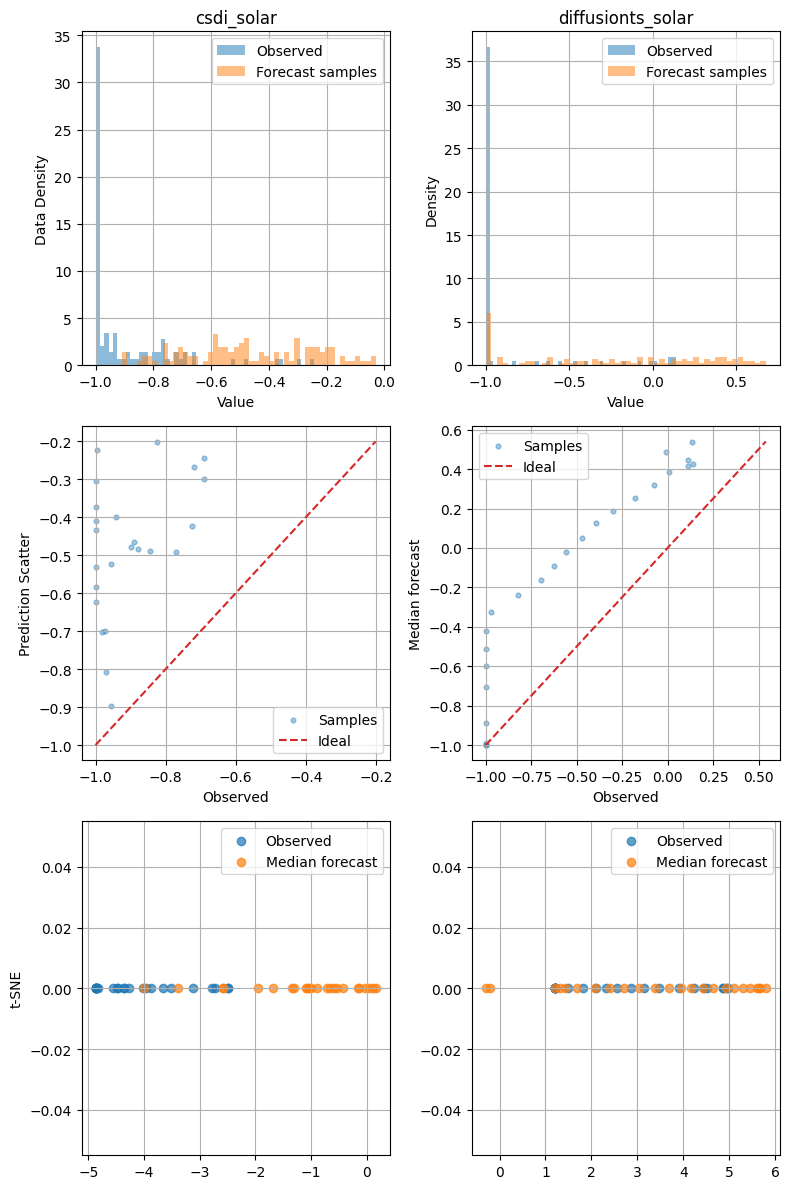

In [4]:
PlotComparisonModelGrid(eval_foldernames=["csdi_solar", "diffusionts_solar"], nsample=NSAMPLE, sample_index=90, feature_index=3)